## Model Selection: Multiple Linear Regression and Principal Component Analysis

*By Juan Vega*

The goal of this notebook is to fit a multiple linear regression notebook and evaluate its ability to predict the death rate per capita per 100,000 population. Principal Component Analysis will be used to understand which features have the most explanatory power and perform dimensionality reduction.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

### Ingest the data source of COVID-19 death rate and additional features from the CDC and other data sources

In [2]:
covid_df = pd.read_csv('./data/merged_dataset.csv')
covid_df.head()

,county,county_fips_code,cases,deaths,stname,ctyname,tot_pop,deaths_per_hun_thou,cnty_name,unemployment_rate,...,SVI__B,SVI__C,SVI__D,tot_male,tot_female,tot_wa_pop,tot_ba_pop,tot_aa_pop,tot_na_pop,minority_group_total
0,Autauga,1001,12738,163.0,Alabama,Autauga County,55869.0,291.753924,"Autauga County, AL",4.9,...,1.0,0.0,0.0,27092,28777,42607,11237,656,58,11237
1,Baldwin,1003,47143,605.0,Alabama,Baldwin County,223234.0,271.016064,"Baldwin County, AL",5.6,...,0.0,0.0,0.0,108247,114987,195198,19593,2380,154,19593
2,Barbour,1005,4741,83.0,Alabama,Barbour County,24686.0,336.222960,"Barbour County, AL",7.0,...,0.0,0.0,1.0,13064,11622,12134,11906,116,52,11906
3,Bibb,1007,5385,95.0,Alabama,Bibb County,22394.0,424.220773,"Bibb County, AL",6.6,...,0.0,1.0,0.0,11929,10465,17191,4763,48,26,4763
4,Blount,1009,12648,203.0,Alabama,Blount County,57826.0,351.053159,"Blount County, AL",4.1,...,1.0,0.0,0.0,28472,29354,55412,978,185,67,978


In [3]:
covid_df.shape

(3133, 54)

### Rename certain features

In [4]:
covid_df.rename(columns={'total_staffed_adult_icu_beds_7_day_sum':'tot_staff_adlt_icu_beds',
                        'total_icu_beds_7_day_sum':'total_icu_beds',
                        'inpatient_beds_7_day_sum':'inpatient_beds',
                        'total_adult_patients_hospitalized_confirmed_covid_7_day_sum':'tot_adlt_pat_hosp_covid',
                        'inpatient_beds_used_7_day_sum':'inpatient_beds_used',
                        'total_beds_7_day_sum':'total_beds',
                        'icu_beds_used_7_day_sum':'icu_beds_used'},inplace=True)

In [5]:
features = [col for col in covid_df.columns if covid_df[col].dtypes != 'O']

In [6]:
for col in ['county_fips_code','deaths','deaths_per_hun_thou']:
    features.remove(col)

#### Impute missing data using a median imputer for every feature with missing data

In [7]:
covid_df.isnull().sum()[covid_df.isnull().sum()>0].sort_values(ascending=False)

inpatient_beds_used_covid_7_day_sum                     703
staffed_icu_adult_patients_confirmed_covid_7_day_sum    703
tot_staff_adlt_icu_beds                                 703
total_icu_beds                                          703
inpatient_beds                                          703
tot_adlt_pat_hosp_covid                                 703
inpatient_beds_used                                     703
total_beds                                              703
icu_beds_used                                           703
total_votes                                              26
biden_votes                                              25
trump_votes                                              25
med_per_test_results_positive                            18
county_vac_pct                                            1
SVI__A                                                    1
SVI__B                                                    1
SVI__C                                  

In [8]:
df = covid_df[features+['deaths_per_hun_thou']]

In [9]:
X = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(df.drop(columns='deaths_per_hun_thou')),
                  columns=df.drop(columns='deaths_per_hun_thou').columns)
y = df['deaths_per_hun_thou']

After imputing all missing data with the median of each feature, there are no more missing values in the data set.

In [10]:
X.isnull().sum().sum(), y.isnull().sum().sum()

(0, 0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=43)

Standardize the features for PCA and multiple linear regression.

In [12]:
ss = StandardScaler()
Xs_train = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns)
Xs_test = pd.DataFrame(ss.transform(X_test),columns=X_test.columns)

Instantiate a linear regression model.

In [13]:
lr = LinearRegression()

In [14]:
lr.fit(Xs_train,y_train)

LinearRegression()

In [15]:
y_preds = lr.predict(Xs_test)

Using these features does not produce an R-squared score that is appropriate to model on and compare the performance of these model against the null model.

In [16]:
y_train_null = [np.mean(y_train)] * len(y_train)
y_test_null = [np.mean(y_train)] * len(y_test)

Although the model fit performs better than the null model based on the r-squared metric, the performance of this model is very poor.

In [17]:
r2_score(y_test,y_preds)

-0.9161211468460633

In [18]:
r2_score(y_test_null,y_preds)

-2.546613484336974e+30

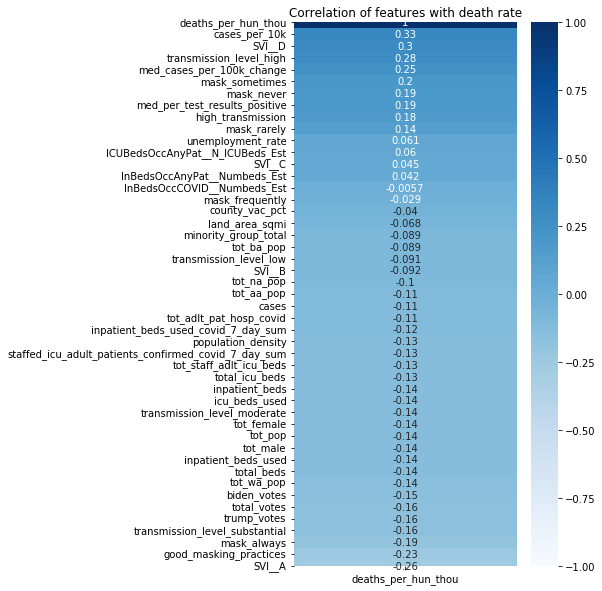

In [19]:
plt.figure(figsize=(5,10))
plt.title('Correlation of features with death rate')
sns.heatmap(df.corr()[['deaths_per_hun_thou']].sort_values(by='deaths_per_hun_thou',ascending=False),
                vmin=-1,
                vmax=1,
                cmap='Blues',
                annot=True);

Attempt fitting a better model using only the featues that are mostly correlated with the death rate based on the correlation heatmap above.

In [20]:
Xs_train = Xs_train[['cases_per_10k','SVI__D','transmission_level_high','med_cases_per_100k_change',
'mask_sometimes','mask_never','med_per_test_results_positive','good_masking_practices','tot_pop']]

Xs_test = Xs_test[['cases_per_10k','SVI__D','transmission_level_high','med_cases_per_100k_change',
'mask_sometimes','mask_never','med_per_test_results_positive','good_masking_practices','tot_pop']]

In [21]:
lr.fit(Xs_train,y_train)

LinearRegression()

In [22]:
y_preds = lr.predict(Xs_test)

In [23]:
r2_score(y_test,y_preds)

0.23897262377278017

This is an improvement from the current model's performance, demonstrating that a lower number of features may return better results. However, the performance of this model is not adequate at the moment, which is the reason why a collective decision made to fit a classification model for whether the median number of deaths is above the 75th percentile across all U.S. counties.

As an exercise, apply principal component analysis to identify which features explain most of the variation in the data in this model.

In [24]:
X = X[['cases_per_10k','SVI__D','transmission_level_high','med_cases_per_100k_change',
'mask_sometimes','mask_never','med_per_test_results_positive','good_masking_practices','tot_pop']]

In [25]:
Xs = ss.fit_transform(X)

In [26]:
pca = PCA().fit(Xs)

It appears that about 82% of the variation in the data can be explained by the first principal components, which are described below.

In [27]:
sum(pca.explained_variance_ratio_[:5])

0.8221167236745869

In [28]:
pca.explained_variance_ratio_

array([0.29710798, 0.20332594, 0.12393948, 0.1042198 , 0.09352353,
       0.07459127, 0.06017558, 0.03431431, 0.00880211])

* The first principal component explains around 30% of the variation in the data and appears to describe counties where a higher number of cases per capita is associated with a lower death rate, where a higher level of social vulnerability is associated with a lower death rates, and where higher transmissibility is assoficated with lower death rates, which are counterintuitive results
* The second principal compoennt appears to describe cases where higher number of COVID cases relate to higher death rates, where higher social vulnerability is associated with higher death rates, and higher transmission is associated with higher death rates. This principal component accounts for 20% of the variation in the data.

In [29]:
pca1_evec = pca.components_[0]

for weight, feature in zip(pca1_evec, X.columns):
    print(feature, weight)
    
# This code is inspired from Sophie's lesson on PCA:
# https://git.generalassemb.ly/dsi-andromeda/pca/blob/master/starter-code-Sophie.ipynb

cases_per_10k -0.3089480936564658
SVI__D -0.09197189404802007
transmission_level_high -0.3180764740841183
med_cases_per_100k_change -0.2637118955151537
mask_sometimes -0.4324201758744859
mask_never -0.4100511630933503
med_per_test_results_positive -0.25535750236559124
good_masking_practices 0.5116536801246182
tot_pop 0.20796521745783844


In [30]:
pca1_evec = pca.components_[1]

for weight, feature in zip(pca1_evec, X.columns):
    print(feature, weight)

cases_per_10k 0.3795728950110919
SVI__D 0.33945688107673044
transmission_level_high 0.4971093726308504
med_cases_per_100k_change 0.38180053008653886
mask_sometimes -0.23748897542207217
mask_never -0.3152618903427621
med_per_test_results_positive 0.17501526691760041
good_masking_practices 0.3495061970528911
tot_pop 0.1980607779158388


In [31]:
covid_df_pca= pd.DataFrame(pca.transform(Xs),columns=['pr_comp_0','pr_comp_1','pr_comp_2','pr_comp_3','pr_comp_4',
                                                      'pr_comp_5','pr_comp_6','pr_comp_7','pr_comp_8'])

In [32]:
cross_val_score(LinearRegression(),
                covid_df_pca,
                covid_df['deaths_per_hun_thou'],
                cv=5).mean()

0.1637549960065414

In [33]:
cross_val_score(LinearRegression(),
                covid_df_pca.drop(columns=['pr_comp_5','pr_comp_6','pr_comp_7','pr_comp_8']),
                covid_df['deaths_per_hun_thou'],
                cv=5).mean()

0.16452918071970715

Using the first five principal components from the reduced data set returns a cross validated r-square score of 16%, which is a lower explanatory model compared to a previous linear regression model without PCA.

Because none of these performances are adequate, it is recommended that other predictive tasks such as classifying counties as having a death rate that is above the 75th percentile are applied instead of multiple linear regression.